# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [3]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [4]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [5]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            #Get a list of training images
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        #dictionary to keep track of all these images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid'];
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        #return total number of traning examples
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        #given index return corresponding example
        class_name = random.choice(self.class_names)
        #to counter imbalance in training set
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        #load the image. convert to RGB as using resNet trained on imageNet dataset
        image = Image.open(image_path).convert('RGB')
        #transform is to convert image to tensor & normalize it
        return self.transform(image), self.class_names.index(class_name)
        

        
            
            

# Image Transformations

In [6]:
#create transform objects for training and test set
#size limitation as you are using pre-trained model
#HorizontalFlip for data augumentation as covid training images are less
#Normalize to normalize it in the same way as imagenet was normalized
#mean and std from imagenet
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std=[0.229, 0.224, 0.225])   
])

In [7]:
#do not use augumentation in test/validation
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std=[0.229, 0.224, 0.225])   
])
#Do not use augumentation in test/validatin

# Prepare DataLoader

In [8]:
#Iterators which will use dataset object and fetch examples and give to mmodel
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)


Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [9]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)


Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [10]:
batch_size = 6
#Shuffle the examples while loading. Don't pick in sequence
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                     shuffle=True)
print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 470
Number of test batches 15


# Data Visualization

In [11]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        #display all six from the same batch in the same row
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        #convert tensor image to numpy array and transpose [channel, height, width]
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        #undo the effect of normalisation
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        color = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=color)
    plt.tight_layout()
    plt.show()

        
    

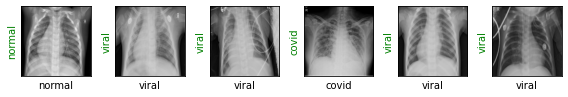

In [12]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

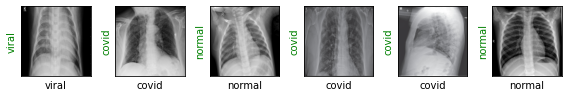

In [13]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [14]:
#import resnet18 from torchvision
#Make sure you use pre-trained weights
resnet18 = torchvision.models.resnet18(pretrained=True)
#print(resnet18)

In [15]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [16]:
def show_preds():
    #set the model to evaulation mode
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
    

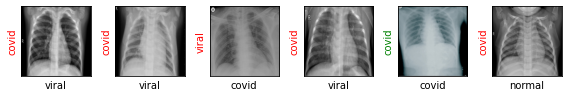

In [17]:
show_preds()

# Training the Model

In [26]:
#Train the model
def train(epochs):
    #Iterations for each training step in one epoch
    print('Starting training....')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print ('='*20)
        
        train_loss = 0.
        val_loss = 0.
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #Back propagation
            loss.backward()
            #Take gradient step to update param values
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satisfied..')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
                    
            
                
        
        

Starting training....
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.1643, Acc: 0.3333


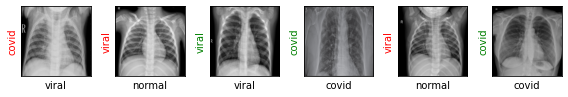

Evaluating at step 20
Val loss: 0.7000, Acc: 0.6778


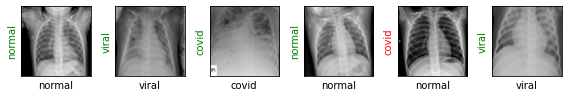

Evaluating at step 40
Val loss: 0.2486, Acc: 0.9556


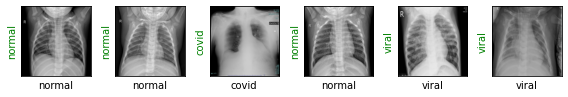

Performance condition satisfied..


In [27]:
train(epochs=1)

# Final Results

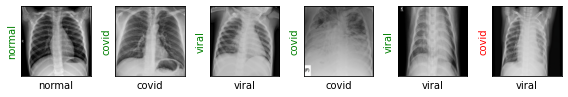

In [29]:
show_preds()